## Installation

In [1]:
#@title Install necessary dependencies.

!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install imageio
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]

from IPython.display import clear_output
clear_output()

In [2]:
#@title Import modules.
#python3

%%capture
import copy
import pyvirtualdisplay
import imageio 
import base64
import IPython


from acme import environment_loop
from acme.tf import networks
from acme.adders import reverb as adders
from acme.agents.tf import actors as actors
from acme.datasets import reverb as datasets
from acme.wrappers import gym_wrapper
from acme import specs
from acme import wrappers
from acme.agents.tf import d4pg
from acme.agents import agent
from acme.tf import utils as tf2_utils
from acme.utils import loggers

import gym 
import dm_env
import matplotlib.pyplot as plt
import numpy as np
import reverb
import sonnet as snt
import tensorflow as tf

# Import dm_control if it exists.
try:
  from dm_control import suite
except (ModuleNotFoundError, OSError):
  pass

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Environnement

In [3]:
environment = gym_wrapper.GymWrapper(gym.make('MountainCarContinuous-v0'))
environment = wrappers.SinglePrecisionWrapper(environment)
def render(env):
  return env.environment.render(mode='rgb_array')

# Show the frame.
frame = render(environment)
plt.imshow(frame)
plt.axis('on')

(-0.5, 599.5, 399.5, -0.5)

### Environement specs

In [4]:
environment_spec = specs.make_environment_spec(environment)

# Agent choice

In [5]:
#@title Build agent networks


# Get total number of action dimensions from action spec.
num_dimensions = np.prod(environment_spec.actions.shape, dtype=int)

# Create the shared observation network; here simply a state-less operation.
observation_network = tf2_utils.batch_concat

# Create the deterministic policy network.
policy_network = snt.Sequential([
    networks.LayerNormMLP((256, 256, 256), activate_final=True),
    networks.NearZeroInitializedLinear(num_dimensions),
    networks.TanhToSpec(environment_spec.actions),
])

# Create the distributional critic network.
critic_network = snt.Sequential([
    # The multiplexer concatenates the observations/actions.
    networks.CriticMultiplexer(),
    networks.LayerNormMLP((512, 512, 256), activate_final=True),
    networks.DiscreteValuedHead(vmin=-150., vmax=150., num_atoms=51),
])


In [6]:
# Create a logger for the agent and environment loop.
agent_logger = loggers.TerminalLogger(label='agent', time_delta=10.)
env_loop_logger = loggers.TerminalLogger(label='env_loop', time_delta=10.)

# Create the D4PG agent.
agent = d4pg.D4PG(
    environment_spec=environment_spec,
    policy_network=policy_network,
    critic_network=critic_network,
    observation_network=observation_network,
    sigma=1.0,
    logger=agent_logger,
    checkpoint=False
)

#surcharger methode selection action agent

def actionDecorator(og_function):
  def nestedFunction(*args, **kwargs):
    results = og_function(*args, **kwargs)
    x = np.linspace(-1,1, 35)
    proximity = 10
    index = 0
    for i in range(len(x)):
      if np.abs(results[0] - x[i]) < proximity:
        proximity = np.abs(results[0] - x[i])
        index = i 
    results[0] = x[index]
    #print(results)
    return results
  return nestedFunction

agent.select_action = actionDecorator(agent.select_action)

#2eme possibilitée
#environment_loop.EnvironmentLoop = ma_function



### code acme: EnvironmentLoop Class

In [7]:
"""A simple agent-environment training loop."""

import operator
import time
from typing import Optional

from acme import core
# Internal imports.
from acme.utils import counting
from acme.utils import loggers

import dm_env
from dm_env import specs
import numpy as np
import tree


class EnvironmentLoop(core.Worker):
  """A simple RL environment loop.
    See acme doc for more infos.
  """

  def __init__(
      self,
      environment: dm_env.Environment,
      actor: core.Actor,
      counter: counting.Counter = None,
      logger: loggers.Logger = None,
      should_update: bool = True,
      label: str = 'environment_loop',
  ):
    # Internalize agent and environment.
    self._environment = environment
    self._actor = actor
    self._counter = counter or counting.Counter()
    self._logger = logger or loggers.make_default_logger(label)
    self._should_update = should_update

  def run_episode(self) -> loggers.LoggingData:
    """Run one episode.
    Each episode is a loop which interacts first with the environment to get an
    observation and then give that observation to the agent in order to retrieve
    an action.
    Returns:
      An instance of `loggers.LoggingData`.
    """
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0

    # For evaluation, this keeps track of the total undiscounted reward
    # accumulated during the episode.
    episode_return = tree.map_structure(_generate_zeros_from_spec,
                                        self._environment.reward_spec())
    timestep = self._environment.reset()

    # Make the first observation.
    self._actor.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = self._actor.select_action(timestep.observation)
      timestep = self._environment.step(action)

      # Have the agent observe the timestep and let the actor update itself.
      self._actor.observe(action, next_timestep=timestep)
      if self._should_update:
        self._actor.update()

      # Book-keeping.
      episode_steps += 1

      # Equivalent to: episode_return += timestep.reward
      tree.map_structure(operator.iadd, episode_return, timestep.reward)

    # Record counts.
    counts = self._counter.increment(episodes=1, steps=episode_steps)

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode_length': episode_steps,
        'episode_return': episode_return,
        'steps_per_second': steps_per_second,
    }
    result.update(counts)
    return result

  def run(self,
          num_episodes: Optional[int] = None,
          num_steps: Optional[int] = None):
    """Perform the run loop.
    Run the environment loop either for `num_episodes` episodes or for at
    least `num_steps` steps (the last episode is always run until completion,
    so the total number of steps may be slightly more than `num_steps`).
    At least one of these two arguments has to be None.
    Upon termination of an episode a new episode will be started. If the number
    of episodes and the number of steps are not given then this will interact
    with the environment infinitely.
    Args:
      num_episodes: number of episodes to run the loop for.
      num_steps: minimal number of steps to run the loop for.
    Raises:
      ValueError: If both 'num_episodes' and 'num_steps' are not None.
    """

    if not (num_episodes is None or num_steps is None):
      raise ValueError('Either "num_episodes" or "num_steps" should be None.')

    def should_terminate(episode_count: int, step_count: int) -> bool:
      return ((num_episodes is not None and episode_count >= num_episodes) or
              (num_steps is not None and step_count >= num_steps))

    episode_count, step_count = 0, 0
    while not should_terminate(episode_count, step_count):
      result = self.run_episode()
      episode_count += 1
      step_count += result['episode_length']
      # Log the given results.
      self._logger.write(result)


def _generate_zeros_from_spec(spec: specs.Array) -> np.ndarray:
  return np.zeros(spec.shape, spec.dtype)


# Loop to output a graph

In [8]:
# Create an loop connecting this agent to the environment created above.
env_loop = environment_loop.EnvironmentLoop(environment, agent, logger=env_loop_logger)

#a = env_loop.run_episode()
#print(a['episode_return'])

def my_run(self,
          num_episodes: Optional[int] = None,
          num_steps: Optional[int] = None):
    """Perform the run loop.
    Run the environment loop either for `num_episodes` episodes or for at
    least `num_steps` steps (the last episode is always run until completion,
    so the total number of steps may be slightly more than `num_steps`).
    At least one of these two arguments has to be None.
    Upon termination of an episode a new episode will be started. If the number
    of episodes and the number of steps are not given then this will interact
    with the environment infinitely.
    Args:
      num_episodes: number of episodes to run the loop for.
      num_steps: minimal number of steps to run the loop for.
    Raises:
      ValueError: If both 'num_episodes' and 'num_steps' are not None.
    """

    return_list = []
    episode_list = []

    if not (num_episodes is None or num_steps is None):
      raise ValueError('Either "num_episodes" or "num_steps" should be None.')

    def should_terminate(episode_count: int, step_count: int) -> bool:
      return ((num_episodes is not None and episode_count >= num_episodes) or
              (num_steps is not None and step_count >= num_steps))

    episode_count, step_count = 0, 0
    while not should_terminate(episode_count, step_count):
      result = self.run_episode()
      episode_count += 1
      step_count += result['episode_length']
      # Log the given results.
      self._logger.write(result)
      # new inndications to print sth
      return_list.append(result["episode_return"])
      episode_list.append(episode_count)

    return episode_list, return_list


environment_loop.EnvironmentLoop.run = my_run

# Run a `num_episodes` training episodes.
# Rerun this cell until the agent has learned the given task.
episode_list, return_list = env_loop.run(num_episodes=300)



[Agent] Critic Loss = 3.944 | Policy Loss = 0.500 | Steps = 1 | Walltime = 0
[Env Loop] Episode Length = 999 | Episode Return = -51.96737289428711 | Episodes = 2 | Steps = 1998 | Steps Per Second = 123.406
[Agent] Critic Loss = 3.734 | Policy Loss = 0.039 | Steps = 367 | Walltime = 10.021
[Env Loop] Episode Length = 999 | Episode Return = -50.86669921875 | Episodes = 5 | Steps = 4995 | Steps Per Second = 290.803
[Agent] Critic Loss = 3.512 | Policy Loss = 0.001 | Steps = 729 | Walltime = 20.030
[Env Loop] Episode Length = 999 | Episode Return = -59.246150970458984 | Episodes = 8 | Steps = 7992 | Steps Per Second = 260.679
[Agent] Critic Loss = 3.344 | Policy Loss = 0.017 | Steps = 1080 | Walltime = 30.052
[Env Loop] Episode Length = 999 | Episode Return = -58.58980178833008 | Episodes = 13 | Steps = 11477 | Steps Per Second = 289.313
[Agent] Critic Loss = 3.186 | Policy Loss = 0.011 | Steps = 1439 | Walltime = 40.067
[Env Loop] Episode Length = 999 | Episode Return = -63.66929626464844

In [9]:
import matplotlib
matplotlib.use('TkAgg') # it tackles UserWarning Issue
import matplotlib.pyplot as plt
%matplotlib inline

# graph

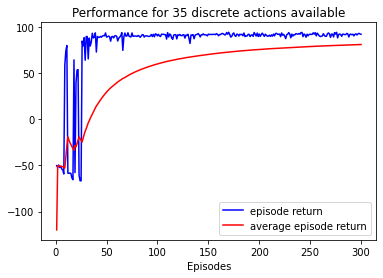

In [10]:

average_return_list =[-120]
avg = 0
for i in range(1,len(return_list)):
  avg = sum(return_list[:i])/len(return_list[:i])
  average_return_list.append(avg)

plt.plot(episode_list, return_list, label= "episode return", c='b')
plt.plot(episode_list, average_return_list , label= "average episode return", c='r')
plt.legend(loc = 'lower right')
plt.xlabel('Episodes')
plt.title('Performance for 35 discrete actions available')
plt.show()

# Display


In [11]:
def display_video(frames, filename='temp.mp4'):
  """Save and display video."""
  # Write video
  with imageio.get_writer(filename, fps=60) as video:
    for frame in frames:
      video.append_data(frame)
  # Read video and display the video
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)
  
timestep = environment.reset()
frames = [render(environment)]

while not timestep.last():
  # Simple environment loop.
  action = agent.select_action(timestep.observation)
  timestep = environment.step(action)

  # Render the scene and add it to the frame stack.
  frames.append(render(environment))

# Save and display a video of the behaviour.
display_video(np.array(frames))

